# Economics 691-06: Assignment 5
#### Armen Khachatrian
##### Collaboration with Joseph Oon

## Problem:  Shrinkage

The data scientists at Youtube have been running a series of week-long experiments to improve time  spent  on  the  platform.   Specifically,  the  Youtube  team  has  run  fifty  experiments  over  the last few months, each of which includes 2,000 users, split between 1,000 treated and 1,000 control users.  For each experiment and for each user in that experiment, Youtube records the change in time spent on the website (in minutes) for that week,  relative to the user’s previous week.  The data scientists have of course analyzed each experiment in isolation and using standard frequentist approaches;  but they have asked you to explore if shrinkage analysis can potentially improve on the estimates of the treatment effect. The raw data from these fifty experiments is in the file data assignment5_1.csv.  The file has 100,000 rows.  Each row corresponds to a separate user in a separate experiment, for which there are three columns.  The first column is the change in time spent on the website.  The second column is an indicator for whether they are in the treated or control group.  The third column indicates which experiment (1 - 50) that the user is in. While the true treatment effects are generally unknown in practice, I have provided them in the file data assignment5_2.csv to illustrate the improvements in the various techniques.  This file has
50 rows.  Each row corresponds to a separate experiment,  for which there are two columns:  the true treatment effect in the first column, and the experiment number in the second column.  Note that this file should only be used for assessing the mean-squared error of your estimated treatment effects, and not for generating those estimates in the first place.

#### EDA (dataset: data assignment5_1.csv)

In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data_assignment5_1.csv')
data.head()

,outcome,treatment,experiment_number
0,-21.648186,1,1
1,-11.598603,1,1
2,-5.958612,1,1
3,-17.126220,1,1
4,-16.658352,1,1


In [3]:
data.shape

(100000, 3)

In [4]:
data.isnull().sum()

outcome              0
treatment            0
experiment_number    0
dtype: int64

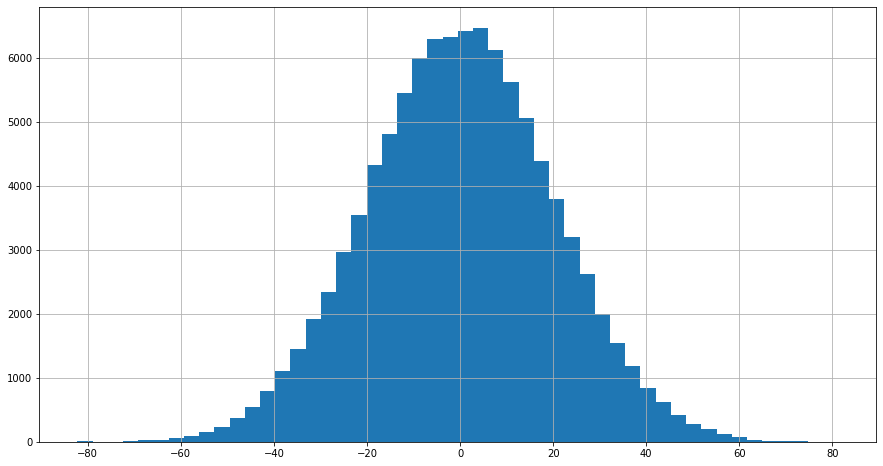

In [5]:
data.outcome.hist(bins=50, figsize=(15,8))
plt.show()

In [6]:
data.experiment_number.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [7]:
data.treatment.unique()

array([1, 0])

In [8]:
data[data.experiment_number == 1]

,outcome,treatment,experiment_number
0,-21.648186,1,1
1,-11.598603,1,1
2,-5.958612,1,1
3,-17.126220,1,1
4,-16.658352,1,1
...,...,...,...
1995,19.596830,0,1
1996,4.988050,0,1
1997,22.235978,0,1
1998,-11.322655,0,1


-----------------------------

> 1. (10 points) Using the experimental data only, estimate the effect of each of the fifty experiments per standard (i.e.  frequentist) regression analysis.  Report the mean-squared error of your estimates across the fifty experiments, by comparing them to the true treatment effects.

In [9]:
effect = []
for i in data.experiment_number.unique():
    model1 = sm.ols(formula="outcome ~ treatment", data=data[data.experiment_number == i]).fit()
    effect.append(model1.params[1])

In [10]:
effect[1:5]

[-2.3267941619375074,
 1.8006478196943192,
 -2.1840877302139408,
 0.2390950751034059]

In [11]:
lst1 = range(1, 51)
df = pd.DataFrame(
    {'Experiment_number': lst1,
     'Treatment_effect': effect
    })
df.head(10)

,Experiment_number,Treatment_effect
0,1,1.951373
1,2,-2.326794
2,3,1.800648
3,4,-2.184088
4,5,0.239095
5,6,0.745346
6,7,0.613068
7,8,3.505125
8,9,0.922175
9,10,0.553500


*Note:* The new DataFrame with estimated treatment effects for each experiment. Here we presented the estimated treatment effect of the first 10 experiments.

In [12]:
#download the dataset with true treatment effect
data_true = pd.read_csv('data_assignment5_2.csv')
#calculate the mean
print("The mean-squared error of the simple estimate is: " + 
      str(round(np.mean((df.Treatment_effect - data_true.true_effect)**2), 4)))

The mean-squared error of the simple estimate is: 1.0606


***Conclusion:*** The mean-squared error of the simple estimate is: 1.0606

> 2. (15 points) Using the James-Stein estimator, adjust your estimates from Question 1.  Report the shrinkage factor that you are using. Then report the mean-squared error of your estimates, by comparing them to the true treatment effects.

In [13]:
sd = np.std(df.Treatment_effect) #calculating standard deviation of the observed treatment effect

In [14]:
factor_js = (1 - (sd**2)*(len(effect) - 2)/sum(df.Treatment_effect**2))#factor James-Stein
print("The factor is: " + str(round(factor_js, 4)))

The factor is: 0.0518


In [15]:
print("The mean-squared error of the adjusted estimate (James-Stein): " + 
      str(round(np.mean((df.Treatment_effect * factor_js - data_true.true_effect)**2), 4)))

The mean-squared error of the adjusted estimate (James-Stein): 1.3605


***Conclusion:*** The mean-squared error of the adjusted estimate (James-Stein): 1.3605

> 3. (15 points) Using the split-sample empirical Bayesian estimator, adjust your estimates from Question 1.  Report the parameters of the shrinkage model you are using.  Then report the mean-squared error of your estimates, by comparing them to the true treatment effects.

In [16]:
#the split-sample empirical Bayesian estimator
#Step-by-step
#1. Take a set of experiments and split each into half
# Split data into two folds
model_coef1 = []
model_coef2 = []
for i in data.experiment_number.unique():
    np.random.seed(10)
    treatment_i = np.where((data.experiment_number == i) & (data['treatment'] == 1))[0]
    control_i = np.where((data.experiment_number == i) & (data['treatment'] == 0))[0]
    index1 = np.random.choice(treatment_i, round(len(treatment_i)/2), replace = False)
    index1 = np.append(index1, np.random.choice(control_i, round(len(control_i)/2), replace = False)) #1st half
    index2 = list(set(data.loc[(data.experiment_number == i)].index) - set(index1)) #2nd half
#2.Estimate a treatment effect within each half
    model1 = sm.ols(formula="outcome ~ treatment", 
                    data = data.iloc[index1]).fit()
    model2 = sm.ols(formula="outcome ~ treatment", 
                    data = data.iloc[index2]).fit()
    model_coef1.append(model1.params[1])
    model_coef2.append(model2.params[1])

In [17]:
len(model_coef1) #checking the length of predicted coef

50

In [18]:
len(model_coef2)

50

In [19]:
regression_df = pd.DataFrame(
    {'Model1_treatment': model_coef1,
     'Model2_treatment': model_coef2
    })
regression_df.head(10) #Dataframe: Coefficients for each half and experiments

,Model1_treatment,Model2_treatment
0,2.024285,1.878460
1,-1.386206,-3.267382
2,0.835850,2.765446
3,-2.249633,-2.118543
4,-0.211651,0.689841
5,1.737354,-0.246663
6,0.568540,0.657596
7,3.575874,3.434375
8,1.091343,0.753007
9,-0.064122,1.171122


In [20]:
#3. Regress the first treatment effect on the second
#how much we need to shrink
#0.7022
model = sm.ols('Model2_treatment ~ Model1_treatment', data = regression_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Model2_treatment   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     35.82
Date:                Mon, 05 Oct 2020   Prob (F-statistic):           2.64e-07
Time:                        00:09:52   Log-Likelihood:                -89.368
No. Observations:                  50   AIC:                             182.7
Df Residuals:                      48   BIC:                             186.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1050      0.211  

In [21]:
factor_Bayes = model.params[1]
print("The mean-squared error of the adjusted estimate is (Bayes): " + 
      str(round(np.mean((df.Treatment_effect * factor_Bayes - data_true.true_effect)**2), 4)))

The mean-squared error of the adjusted estimate is (Bayes): 0.6031


***Conclusion:*** The mean-squared error of the adjusted estimate is (Bayes): 0.6031, shrinkage parameter: 0.7022

> 4. (20 points) Using LASSO, create new estimates of treatment effects for each experiment. In  order  to  tune  the  parameter $\alpha$,  demonstrate  two  different  cross-validation  approaches, both  using  the  mean-squared  error  in  the  predicted  versus  actual  response  values  as  the metric.  First, set the optimal $\alpha$ within each experiment, defined as the alpha correspondingto the lowest mean-squared error for that experiment.  Second, find the optimal $\alpha$ across all experiments,  defined  as  the  alpha  corresponding  to  the  lowest  average  mean-squared  error across all experiments.  For this second approach, report the optimal $\alpha$ you find.  Under both approaches, you should use five cross-validation folds.  Once you have generated your set of estimates for each of the two tuning approaches, report the mean-squared error for that set of estimates, by comparing them to the true treatment effects.  Thus, you should have two mean-squared errors for this question.

* You should search $\alpha$ ∈ [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100].  You also should not use any inbuilt functions to search for the optimal $\alpha$, such as GridSearchCV (Python); but should code from scratch, as we did in class.

* As a hint, remember that you fit each experiment and compute each metric (e.g.  mean-squared  error  between $\hat{y}$ and y)  individually  under  both  approaches.   The  difference between computing a per-experiment or pooled $\alpha$ only comes once you have all metrics. At that point,  you can either find the minimum metric and corresponding $\alpha$ for each experiment; or you can find the average minimum metric and corresponding $\alpha$ across all experiments.

* Given the number of folds and the variation in inputs, you are strongly encouraged to write a modular function to keep your code efficient and readable.

In [22]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 10) #split way
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
diff = []
lst = []
for i in data.experiment_number.unique(): #we have 50 experiments
    for alpha in alphas: # 11 alpha values
        lassoreg = Lasso(alpha, normalize = True, fit_intercept = True, random_state = 10)
        for k in range(5): #5 Fold CV
            result = next(kf.split(data[['treatment']].loc[data.experiment_number == i]), None)
            x_train = data[['treatment']].loc[data.experiment_number == i].iloc[result[0]]
            x_test = data[['treatment']].loc[data.experiment_number == i].iloc[result[1]]
            y_train = data['outcome'].loc[data.experiment_number == i].iloc[result[0]]
            y_test = data['outcome'].loc[data.experiment_number == i].iloc[result[1]] #actual values
            lassoreg.fit(x_train,y_train)
            y_pred = lassoreg.predict(x_test)#400 predictions
            diffsq = (y_pred - y_test)**2
            diff.append(diffsq)
        mse = np.mean(diff) #calc mse
        lst.append(mse)
        diff.clear()

In [23]:
mse_list = []
for i in range(len(lst)):
    mse_list.append(float(lst[i]))
df_mse = pd.DataFrame(mse_list,columns=['MSE'])

In [24]:
df_mse.loc[df_mse.iloc[:11].index, 'Experiment_number'] = 1
for i in range(49):
    df_mse.loc[df_mse.iloc[11+11*i:22+11*i].index, 'Experiment_number'] = i+2

In [25]:
n = 50
alphas50 = alphas*n

In [26]:
#DF calculated CV MSE for each experiment and alpha values. Overall, 550 observations
df_mse['Alpha'] = alphas50
df_mse.head(15) # cross-validation MSE

,MSE,Experiment_number,Alpha
0,393.754360,1.0,0.001
1,393.860502,1.0,0.005
2,394.065208,1.0,0.010
3,395.003727,1.0,0.050
4,395.003727,1.0,0.100
5,395.003727,1.0,0.500
6,395.003727,1.0,1.000
7,395.003727,1.0,5.000
8,395.003727,1.0,10.000
9,395.003727,1.0,50.000


In [27]:
#1st approach: min MSE for each experiment
dff = df_mse.loc[df_mse.groupby('Experiment_number')['MSE'].idxmin()]
dff.shape

(50, 3)

In [28]:
dff.head()

,MSE,Experiment_number,Alpha
0,393.754360,1.0,0.001
13,390.466394,2.0,0.010
25,434.445266,3.0,0.050
33,408.177065,4.0,0.001
47,367.029973,5.0,0.050


#### 1st approach

In [29]:
#1st approach LASSO regression
lst = []
for i in range(len(dff.Alpha)):
    #run LASSO regression with each particular alpha value
    lassoreg = Lasso(alpha = dff.Alpha.iloc[i], fit_intercept=True, normalize=True, random_state=10) 
    x = data[['treatment']].loc[data.experiment_number == i+1]
    y = data['outcome'].loc[data.experiment_number == i+1]
    lassoreg.fit(x, y)
    lst.append(lassoreg.coef_)

In [30]:
experiment_number = range(1, 51)
df1 = pd.DataFrame(
    {'Experiment_number': experiment_number,
     'Coef': lst
    })
mse_1 = np.mean((df1.Coef - data_true.true_effect)**2)
mse_1 #this approach can lead to overfitting. 
#We have only 50 coefficients, so it is hard to estimate the presence of overfitting
#Moreover, we can guess that choosing the specific alpha level for each experiment tends to overfit the model 

array([1.0628848])

#### 2nd approach

In [31]:
#2nd approach LASSO regression
df_mse.MSE.groupby(df_mse.Alpha).mean()

Alpha
0.001      402.677403
0.005      402.637709
0.010      402.641720
0.050      403.071442
0.100      403.145660
0.500      403.145660
1.000      403.145660
5.000      403.145660
10.000     403.145660
50.000     403.145660
100.000    403.145660
Name: MSE, dtype: float64

In [32]:
df_mse.MSE.groupby(df_mse.Alpha).mean().min()

402.6377088773912

In [33]:
lst2 = []
for i in range(50): #we found that the minimum MSE is obtained via alpha = 0.005
    lassoreg = Lasso(alpha = 0.005, normalize = True, fit_intercept = True)
    x = data[['treatment']].loc[data.experiment_number == i+1]
    y = data['outcome'].loc[data.experiment_number == i+1]
    lassoreg.fit(x, y)
    lst2.append(lassoreg.coef_)

In [34]:
experiment_number = range(1, 51)
df2 = pd.DataFrame(
    {'Experiment_number': experiment_number,
     'Coef2': lst2
    })
mse_2 = np.mean((df2.Coef2 - data_true.true_effect)**2)
mse_2

array([0.74766054])

***Conclusion:*** 

1) MSE 1st approach: 1.0628848

2) MSE 2nd approach: 0.74766054

> 5. (10 points) Using  Ridge  Regression,  create  new  estimates  of  treatment  effects  for  each experiment, utilizing a third cross-validation approach.  Continue to use five cross-validation folds,  and  continue  to  find  the  optimal $\alpha$ across  all  experiments  (rather  than  within  each experiment)  as  in  the  second  approach  previously.   However,  now  use  the  mean-squared difference between the estimated and OLS coefficient as the metric.  Report the optimal $\alpha$ you find.  Moreover, report the mean-squared error of your estimates, by comparing them tothe true treatment effects.

In [35]:
#Ridge Regression
coef_f = []
lst_ = []
for i in data.experiment_number.unique():
    for alpha in alphas:
        ridgereg_ = Ridge(alpha, normalize = True, fit_intercept = True, random_state = 10)
        for k in range(5):
            result = next(kf.split(data[['treatment']].loc[data.experiment_number == i]), None)
            x_train = data[['treatment']].loc[data.experiment_number == i].iloc[result[0]]
            x_test = data[['treatment']].loc[data.experiment_number == i].iloc[result[1]]
            y_train = data['outcome'].loc[data.experiment_number == i].iloc[result[0]]
            y_test = data['outcome'].loc[data.experiment_number == i].iloc[result[1]] #actual values
            ridgereg_.fit(x_train,y_train)
            coef = ridgereg_.coef_#400 predictions ///just predict (RETURN COEF)
            coef_f.append(coef)
        mean_coef = np.mean(coef_f)
        lst_.append(mean_coef)
        coef_f.clear()
#/compare coef ols coef is biased - no biased (law ln) and compare with real data result

In [36]:
#Dataframe: particular alpha value with each mean RR coefficient
mean_coef_r = []
for i in range(len(lst_)):
    mean_coef_r.append(float(lst_[i]))
df_r_coef = pd.DataFrame(mean_coef_r,columns=['Mean_coef_ridge'])
df_r_coef.loc[df_r_coef.iloc[:11].index, 'Experiment_number'] = 1
for i in range(49):
    df_r_coef.loc[df_r_coef.iloc[11+11*i:22+11*i].index, 'Experiment_number'] = i+2
df_r_coef['Alpha'] = alphas50
df_r_coef.Mean_coef_ridge.groupby(df_r_coef.Alpha).mean()

Alpha
0.001      0.287223
0.005      0.286080
0.010      0.284663
0.050      0.273819
0.100      0.261373
0.500      0.191673
1.000      0.143755
5.000      0.047918
10.000     0.026137
50.000     0.005637
100.000    0.002847
Name: Mean_coef_ridge, dtype: float64

In [37]:
#calcualting mean-squared difference between 
#the estimated and OLS coefficient for each experiment and alpha value
msd_coef = []
for e in experiment_number:    
    for i in alphas:
        coef_r = df_r_coef.Mean_coef_ridge
        coef_ols = df.Treatment_effect
        diff = float(coef_r.loc[(df_r_coef.Alpha == i) & (df_r_coef.Experiment_number == e)]) - coef_ols.loc[df.Experiment_number == e]
        diffsq = diff**2
        msd_coef.append(diffsq)
        
n = 50
alphas50 = alphas*n
msd_ = []
for i in range(len(msd_coef)):
    msd_.append(float(msd_coef[i]))
df_msd_c = pd.DataFrame(msd_,columns=['MSD'])
df_msd_c['Alpha'] = alphas50
#DF: the averaged MSD for each alpha
df_msd_c.groupby(df_msd_c.Alpha).mean()

,MSD,Alpha
Alpha,,
0.001,0.233291,0.001
0.005,0.232547,0.005
0.010,0.231750,0.010
0.050,0.230178,0.050
0.100,0.238258,0.100
0.500,0.478719,0.500
1.000,0.836201,1.000
5.000,2.020899,5.000
10.000,2.377496,10.000


In [38]:
#min msd
df_msd_c.groupby(df_msd_c.Alpha).mean().min()

MSD    0.230178
dtype: float64

In [39]:
#
#alpha = 0.05
lst_r_ = []
for i in range(50):
    ridgereg = Ridge(alpha = 0.05, normalize = True, fit_intercept = True)
    x = data[['treatment']].loc[data.experiment_number == i+1]
    y = data['outcome'].loc[data.experiment_number == i+1]
    ridgereg.fit(x, y)
    lst_r_.append(ridgereg.coef_)
experiment_number = range(1, 51)
df2r = pd.DataFrame(
    {'Experiment_number': experiment_number,
     'Coef_r': lst_r_
    })

In [40]:
mse_r_true = np.mean((df2r.Coef_r - data_true.true_effect)**2)
mse_r_true

array([0.95354846])

***Conclusion:*** the optimal alpha: 0.05, the mean-squared error: 0.95354846

> 6. (10 points) You  now  have  six  sets  of  estimates  from  six  distinct  approaches:  the  simple frequentist estimates, the James-Stein estimates, the split-sample estimates, the LASSO estimates with the per-experiment $\alpha$, the LASSO experiments with the single $\alpha$, and the Ridge Regression estimates.  On a single histogram or density plot, graph the the differences between the estimated treatment effect and the true treatment effect, across all fifty experiments andusing different colors for each approach.  As always, points will be awarded on the basis ofthe ease of understanding your visualization.

Text(0.5, 1.0, 'The differences between the estimated treatment effect and the true treatment effect')

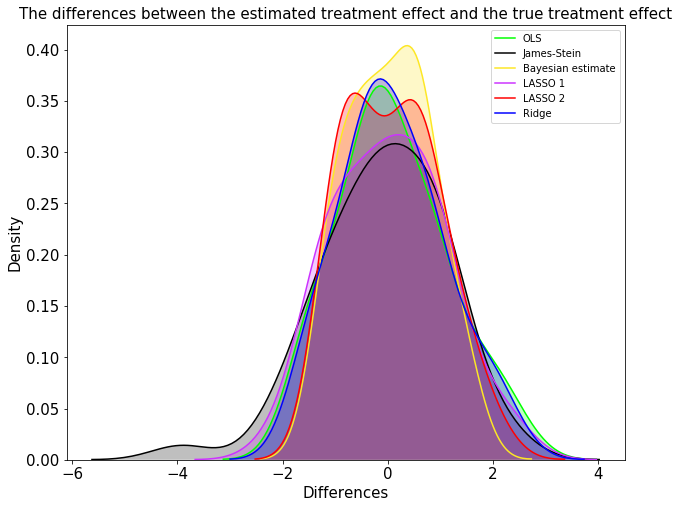

In [41]:
ols = df.Treatment_effect - data_true.true_effect
js = df.Treatment_effect*factor_js - data_true.true_effect
bayes = df.Treatment_effect * factor_Bayes - data_true.true_effect
lasso1 = df1.Coef - data_true.true_effect
lasso2 = df2.Coef2 - data_true.true_effect
rr = df2r.Coef_r - data_true.true_effect
df_ols = pd.DataFrame({'Exp':ols.index, 'Diff': ols.values})
df_js = pd.DataFrame({'Exp':js.index, 'Diff': js.values})
df_bayes = pd.DataFrame({'Exp':bayes.index, 'Diff': bayes.values})
df_lasso1 = pd.DataFrame({'Exp':lasso1.index, 'Diff': lasso1.values})
df_lasso2 = pd.DataFrame({'Exp':lasso2.index, 'Diff': lasso2.values})
df_rr = pd.DataFrame({'Exp':rr.index, 'Diff': rr.values})

plt.figure(figsize=[10,8])


sns.kdeplot(df_ols['Diff'], shade=True, color="#00FF00", label = 'OLS')
sns.kdeplot(df_js['Diff'], shade=True, color="#000000", label = 'James-Stein')
sns.kdeplot(df_bayes['Diff'], shade=True, color="#FDE725FF", label = 'Bayesian estimate')
sns.kdeplot(df_lasso1['Diff'], shade=True, color="#CC33FF", label = 'LASSO 1')
sns.kdeplot(df_lasso2['Diff'], shade=True, color='r', label = 'LASSO 2')
sns.kdeplot(df_rr['Diff'], shade=True, color="#0000FF", label = 'Ridge')

plt.xlabel('Differences',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('The differences between the estimated treatment effect and the true treatment effect',fontsize=15)


> 7. (10 points) Discuss the advantages and disadvantages of each of the six approaches.  Which would  you  recommend  the  Youtube  data  scientists  use  going  forward?   Limit  your  entire answer to approximately three hundred words.

OLS:
The Ordinary Least Squares is one of the easiest and computationally inexpensive ways of prediction if our target is a continuous variable (find a function that best fits the data). According to advantages, OLS is easy to understand and implement, and also this approach converges quickly. However, we have a parametric regression (OLS), and this model tends to be too simple. It's hard to hold assumptions: exogeneity and homoskedasticity when adding a new explanatory variable.

James-Stein:
The James-Stein method is an easy fix to the simple OLS model where we introduce a factor term that reduces the variance in the estimate but increases the bias. This shrinkage factor could be useful if the team can optimize the bias-variance trade-off. However, it is hard to achieve in the real world, more than often, we will end up with a biased estimate.

Bayes split sample:
It requires the researchers to split the data in 2 and use half to determine the degree of shrinkage required to achieve an unbiased estimate. Then apply this shrinkage model to any dataset for an improved estimation. This approach is easy to implement. But theoretically, this method works worse with complicated models because computing a posterior may be extremely difficult.

LASSO:
LASSO approach goal is to improve model accuracy through regularisation/penalization and avoid overfitting/underfitting. To find the most appropriate alpha is hard without using cross-validation. LASSO is also helpful for "sparse" solutions — dropping the number of features from some (too) high number to fewer. When alpha = 0, LASSO generates the same coefficients as OLS, when alpha is large, LASSO generates all-zero coefficients. This approach is computationally expensive when we add more data ( the model should improve (greatly) when adding more data/parameters). Even though we try to avoid overfitting, LASSO 1 can be inappropriate due to choosing the particular threshold level for each experiment (-> overfit), although at the same time choosing only one alpha(LASSO 2) value seems to have a good result.   

Ridge:
Ridge regression is similar to LASSO (same goals, same assumptions, same approach). However, ridge regression does no assign beta to zero, unlike Lasso, and is mostly used to reduce variance without removing covariates. However, in this scenario, we only have 1 covariate. 

In conclusion, I think the best approach for the YouTube data scientists would be to adopt the Bayes split sample strategy for several reasons. First, we assume that in the real world, we do not have the true values to check our answers, using OLS and James-Stein could give us a biased estimate. Next, looking at the dataset corresponding to this scenario, we only have 1 covariate to make LASSO and Ridge inappropriate because these methodologies are mainly used for multi-covariate models. Furthermore, the computation power required to do these computations makes it even less optimal. Hence, I will recommend the Bayes split-sample method. 